# Reaction diffusion exercise

This notebook demonstrates PDE-FIND on a reaction diffusion system exhibiting sprial waves on a periodic domain.  We derive PDE's for each of two quantities, having dependancies on each other; $u$ and $v$.  

\begin{align*}
u_t &= 0.1\nabla^2 u + \lambda(A)u - \omega(A)v\\
v_t &= 0.1\nabla^2 v + \omega(A)u + \lambda(A)v\\
A^2 &= u^2 + v^2,\, \omega(A) = -\beta A^2, \lambda(A) = 1-A^2
\end{align*}

The Singular Value Decomposition is then applied to the result of the equation in order to find the best rank truncation able to well describe the equation drastically reducing the amount of data.

Lastly a Neural Network has been trained in the lower dimensional space for reaction diffusion forecastin and then compared the prediction with actual Reaction Diffusion solution 

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from PDE_FIND import *
import scipy.io as sio
import itertools

from matplotlib.figure import figaspect
import matplotlib.pyplot as plt
import plotly.express as px
from optht import optht
from mpl_toolkits.axes_grid1 import make_axes_locatable

Populating the interactive namespace from numpy and matplotlib


<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Load generated data from MATLAB

In [2]:
data = sio.loadmat('reaction_diffusion_big.mat')

t = data['t'][:,0]
x = data['x'][0,:]
y = data['y'][0,:]
U = data['u']
V = data['v']

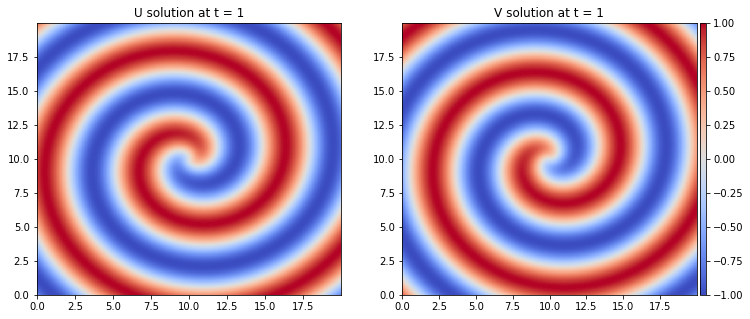

In [3]:
n = len(x)
steps = len(t)
dx = x[2]-x[1]
dy = y[2]-y[1]
dt = t[2]-t[1]

time = 1

xx, yy = np.meshgrid(np.arange(n)*dx,np.arange(n)*dy)

fig, ax = plt.subplots(1,2, figsize=(12,5), gridspec_kw={'width_ratios': [1, 1]})
ax[0].set_title('U solution at t = %d'%time)
im0 = ax[0].pcolormesh(xx, yy, U[:,:,time], cmap='coolwarm', rasterized=True)


ax[1].set_title('V solution at t = %d'%time)  
im1 = ax[1].pcolormesh(xx, yy, V[:,:,time], cmap='coolwarm', rasterized=True)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

plt.show()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Reshape the matrix as single vector

In [4]:
U_reshaped = np.reshape(U,(len(x)*len(y),len(t)))
V_reshaped = np.reshape(V,(len(x)*len(y),len(t)))

reshaped_equation = np.concatenate((U_reshaped,V_reshaped),axis=0)
print(reshaped_equation.shape)

(524288, 201)


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Singular Value Decomposition


In [5]:
u, s, vh = np.linalg.svd(reshaped_equation, full_matrices=False)

In [23]:
confidence_level =0.5 # [%]

# truncation rank
r = x=np.array(np.where(s/max(s)*100> confidence_level))[0,-1]

fig = px.line( title='Diagonal of the eigen values matrix \u03A3')
fig.add_scatter(x = np.arange(0,len(s)),y=s/max(s)*100, name = "Number of significant dimensions", marker =dict(size = 1.5, color='blue'),line = dict(width=1.5))
fig.add_vline(x=np.array(np.where(s/max(s)*100> confidence_level))[0,-1],line_color="red" , annotation_text=' '+str(np.array(np.where(s/max(s)*100> confidence_level))[0,-1])+' -> number of modes containing the '+str(100-confidence_level)+'% of the total system energy')
fig.update_layout(xaxis_title="Dimensions", yaxis_title="Normalized eigen values value", width=1000)

In [7]:
vh.shape

(201, 201)

<br>
<br>
<br>

## Plot reaction diffusion equations projected in the lower space

In [8]:
U_V_denoised = (u[:, range(r)] * s[range(r)]).dot(vh[range(r),:])
U_denoised =  np.reshape(U_V_denoised[0:n*n,:],(n,n,steps))
V_denoised = np.reshape(U_V_denoised[n*n:,:],(n,n,steps))

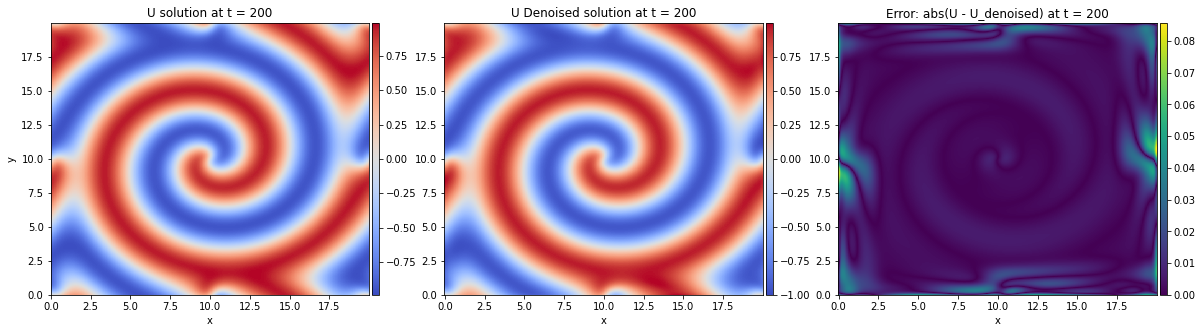

In [25]:
time = 200

fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].set_title('U solution at t = %d'%time)
im0 = ax[0].pcolormesh(xx, yy, U[:,:,time], cmap='coolwarm', rasterized=True)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

ax[1].set_title('U Denoised solution at t = %d'%time)  
im1 = ax[1].pcolormesh(xx, yy, U_denoised[:,:,time], cmap='coolwarm', rasterized=True)
ax[1].set_xlabel('x')

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax[2].set_title('Error: abs(U - U_denoised) at t = %d'%time)
ax[2].set_xlabel('x')
im2 = ax[2].pcolormesh(xx, yy, abs(U[:,:,time]-U_denoised[:,:,time]), cmap='viridis', rasterized=True)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')



plt.show()


In [10]:
vh_denoised = (vh[range(r),:]).T
print(vh_denoised.shape)

(201, 7)


In [11]:
train_X =  vh_denoised[0:-1,:]
train_Y =  vh_denoised[1:,:]

In [12]:
import tensorflow as tf

deep_approx = tf.keras.models.Sequential()
deep_approx.add(tf.keras.layers.Dense(1000, input_dim=train_X.shape[1], activation='relu'))
deep_approx.add(tf.keras.layers.Dense(1000, activation='relu'))
deep_approx.add(tf.keras.layers.Dense(train_Y.shape[1], activation='linear'))

decayRate = 1e-4
nrSamplesPostValid = 2
learningRate = 1e-4
nEpochs = 200
batchSize = 128
verbosity = 1

# Compile model
adam = tf.keras.optimizers.Adam( learning_rate = learningRate, decay = decayRate )
deep_approx.compile(loss='mse', optimizer=adam)

# fit the model
History = deep_approx.fit(train_X, train_Y, epochs=nEpochs )


Train on 200 samples
Epoch 1/200
200/200 [==============================] - 1s 4ms/sample - loss: 0.0043
Epoch 2/200
200/200 [==============================] - 0s 613us/sample - loss: 0.0031
Epoch 3/200
200/200 [==============================] - 0s 639us/sample - loss: 0.0022
Epoch 4/200
200/200 [==============================] - 0s 465us/sample - loss: 0.0015
Epoch 5/200
200/200 [==============================] - 0s 533us/sample - loss: 9.7596e-04
Epoch 6/200
200/200 [==============================] - 0s 506us/sample - loss: 5.6462e-04
Epoch 7/200
200/200 [==============================] - 0s 503us/sample - loss: 3.0734e-04
Epoch 8/200
200/200 [==============================] - 0s 469us/sample - loss: 1.8854e-04
Epoch 9/200
200/200 [==============================] - 0s 490us/sample - loss: 1.2170e-04
Epoch 10/200
200/200 [==============================] - 0s 473us/sample - loss: 1.0709e-04
Epoch 11/200
200/200 [==============================] - 0s 483us/sample - loss: 9.2155e-05
Epoch

<br>
<br>
<br>

## Predict the equation behaviour 

In [13]:
vh_predicted = np.zeros((len(t)-1,len(vh_denoised[0,:])))
vh_predicted[0,:] = vh_denoised[0,:]
for ii in range(1,len(t)-1):
    vh_predicted[ii,:] = deep_approx.predict(np.reshape(vh_predicted[ii-1,:],(1,vh_predicted.shape[1])))

vh_predicted = vh_predicted.T

## Reshape the equation for coming back to the initial dimensions

In [14]:
U_V_predicted = (u[:, range(r)] * s[range(r)]).dot(vh_predicted[range(r),:])
U_predicted =  np.reshape(U_V_predicted[0:n*n,:],(n,n,steps-1))
V_predicted = np.reshape(U_V_predicted[n*n:,:],(n,n,steps-1))

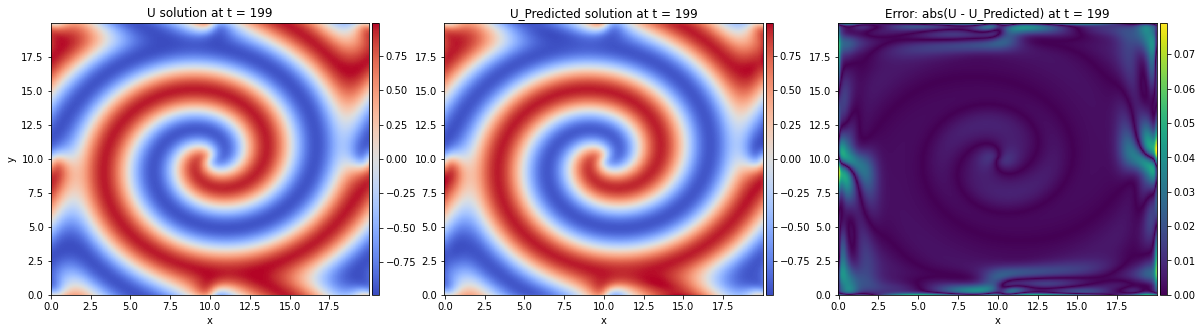

In [28]:
time = 199

fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].set_title('U solution at t = %d'%time)
im0 = ax[0].pcolormesh(xx, yy, U[:,:,time], cmap='coolwarm', rasterized=True)
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')

ax[1].set_title('U_Predicted solution at t = %d'%time)  
im1 = ax[1].pcolormesh(xx, yy, U_predicted[:,:,time], cmap='coolwarm', rasterized=True)
ax[1].set_xlabel('x')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

ax[2].set_title('Error: abs(U - U_Predicted) at t = %d'%time)
im2 = ax[2].pcolormesh(xx, yy, abs(U[:,:,time]-U_predicted[:,:,time]), cmap='viridis', rasterized=True)
ax[2].set_xlabel('x')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='2%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')



plt.show()

In [16]:
# find max sum(err)

sum_err = np.sum(abs(U[:,:,:200]-U_predicted[:,:,:]),axis=2)

for ii in range(sum_err.shape[0]):
    for jj in range(sum_err.shape[1]):
        if(sum_err[ii,jj]<0.01):
            sum_err[ii,jj] = 10


min_element = np.min(sum_err)
print(min_element)

max_element = np.max(sum_err)
print(max_element)

ij_min = np.where(sum_err == min_element)
ij_min = tuple([i.item() for i in ij_min])

ij_max = np.where(sum_err == max_element)
ij_max = tuple([i.item() for i in ij_max])

0.13764185578620503
10.0


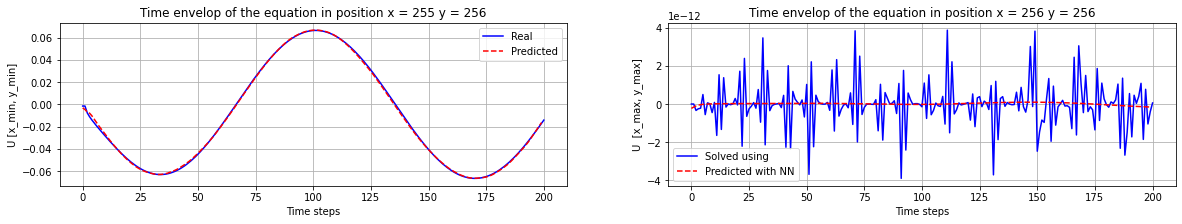

In [17]:

x_position_min = ij_min[0]
y_position_min = ij_min[1]
title_min = 'Time envelop of the equation in position x = '+str(x_position_min) +' y = ' + str(y_position_min)

x_position_max = ij_max[0]
y_position_max = ij_max[1]
title_max = 'Time envelop of the equation in position x = '+str(x_position_max) +' y = ' + str(y_position_max)


fig, ax = plt.subplots(1,2,figsize=(20,3))
ax[0].set_title(title_min)
ax[0].plot(U[x_position_min,y_position_min,:],'b')
ax[0].plot(U_predicted[x_position_min,y_position_min,:],'--r')
ax[0].legend(['Real', 'Predicted'])
ax[0].set_xlabel('Time steps')
ax[0].set_ylabel('U [x_min, y_min]')
ax[0].grid()

ax[1].set_title(title_max)
ax[1].plot(U[x_position_max,y_position_max,:],'b')
ax[1].plot(U_predicted[x_position_max,y_position_max,:],'--r')
ax[1].legend(['Solved using ', 'Predicted with NN'])
ax[1].set_ylabel('U  [x_max, y_max]')
ax[1].set_xlabel('Time steps')
ax[1].grid()
